<h1> Measuring Youngs Modulus of a Ball Spring Model Solid </h1>
<h2> Thomas M. Boudreaux </h2>
<h2> Computational Physics Term Project </h2>

<hr>
<h3>Abstract</h3>
Introductory physics course teach a ball spring model of solids, using only this model it is possible to make numerical simulations demonstrationg traditionally more complex propoerties of solids which do not feature heavily in introductory course work. Here I present a simple method to measure youngs modulus of a 2-Dimensional solid modeled as point masses connected in a lattice of damped springs. This could be adapted to an introductory lab allowing students to investigate emergent properties of solids computationally.

<hr>
<h3>Boilerplate and Initial Conditions</h3>
We start by including the relevant modules. Note that I include the numba module. Numba allows for just in time compilation of python code, drastically speeding up certain steps of the simulation. However, Numba can also me difficult to install, if you are trying to run this notebook and are unable to install Numba simply remove teh import statement and remove all @njit decoraters above functions.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mplEasyAnimate import animation
from tqdm import tqdm
from scipy.special import comb
from scipy.special import factorial
from numba import njit, jit
from scipy.stats import linregress

I will define a function to generate the initial conditions of the lattice. The latice will be comprised of $N_{v}\times N_{h}$ point masses in a rectangular grid, all seperated by the equilibrium length of the springs connecting them (See Below).

<img src="PresentationFigures/BallSpring.png" alt="Drawing" style="width: 500px;"/>

In [2]:
def make_lattice(Nv, Nh, sep):
    lattice = np.zeros(shape=(Nv, Nh, 4))
    for nv in range(Nv):
        for nh in range(Nh):
            lattice[nh, nv] = np.array([nh*sep, nv*sep, 0, 0])
    
    return lattice

The following functions are simply to aid in visulization latter.

In [3]:
def plot_system(y, F=None):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    ax.plot(y[:, 1:-1, 0], y[:, 1:-1, 1], 'C0o')
    if F is not None:
        ax.quiver(y[-1, 1:-1, 0], y[-1, 1:-1, 1], F[0], F[1])
    return fig, ax

In [4]:
def animate_system(filename, ys, F=None, skip=1):
    anim = animation(filename, fps=30)
    for i, y in tqdm(enumerate(ys), total=ys.shape[0]):
        if i%skip == 0:
            fig, ax = plot_system(y, F=F)
            ax.set_xlim(np.min(ys[0, :, 0])-0.1, np.max(ys[-1, :, 0])+0.1)
            ax.set_ylim(np.min(ys[:, 0, 1])-0.1, np.max(ys[:, -1, 1])+0.1)
            anim.add_frame(fig)
            plt.close(fig)
    
    anim.close()

<h3>Model</h3>

We define a 9 part peicwise model to control the numerical integration of our system. Eight parts of this model are to account for boundary conditions with one final part dedicated to all remaining particles. The equations of motion are as follows

$$
    \ddot{x} = -b\dot{x}-\frac{k}{m}\begin{cases}
                            0 & i = j = 0 \\
                            0 & i = 0, j = N_{v} \\
                            0 & i = 0, 0<j<N_{v} \\                        
                            \left[2s-x_{i-1,j}-x_{i, j+1}\right] & i = N_{h}, j = 0 \\
                            \left[2s-x_{i-1,j}-x_{i, j-1}\right] & i = N_{h}, j = N_{v} \\
                            \left[3s-x_{i-1,j}-x_{i, j-1}-x_{i, j+1}\right] & i = N_{h}, 0<j<N_{v} \\
                            \left[3s-x_{i+1,j}-x_{i, j+1}-x_{i-1, j}\right] & 0<i<N_{h}, j=0 \\
                            \left[3s-x_{i+1,j}-x_{i, j-1}-x_{i-1, j}\right] & 0<i<N_{h}, j=N_{v} \\
                            \left[4s-x_{i+1,j}-x_{i, j-1}-x_{i-1, j}-x_{i, j+1}\right] & otherwise \\
               \end{cases}
$$
One area of future improvment which should be considered is automating the calculation of boundary conditions so that they do not have to be manually input.

One side of this model is pinned so that it may not move. I have achived this by calculating the force on those masses as always zero. Note also that the corners where $i=N_{h}$ have only two spring connected to them, so when those springs are offset from eqilibrium the force vector will be striktly inwards towrds the bulk of the solid. This is not a concern for the results of this simulation as the corners, top row, and bottom row of point masses are included to keep all other particles in equilibrium and are not themselves considered to be meaningful particles in the simulation. 

In order to impliment this model I will define three functions. One function to quickly find the vector, magnitude, and unit vector from a given particle to another. A second function to find the force vector acting on a single particle given some list of relative $i, j$ coorindates to connect springs from it to. Finally I define the model function itself where I calculate the acceleration on each particle.

In [5]:
@njit
def getVecs(r1, r2):
    sr = r2-r1
    srmag = np.sqrt(sr[0]**2+sr[1]**2)
    return sr, srmag, sr/srmag

In [6]:
@njit
def getForceComponents(r, v, pList, IDx, IDy, k, b, sep, xoffsets, yoffsets, ts):
    FMag = np.zeros(shape=(2,))
    for oID in range(len(xoffsets)):
        dx = xoffsets[oID]
        dy = yoffsets[oID]
        sr, srmag, srhat = getVecs(r, pList[IDx+dx, IDy+dy, :2])
        if srmag > 0.1:
            FMag += -k*(sep-srmag)*srhat-b*v
    return FMag

In [7]:
@njit
def ym_nbody(I0, IDx, IDy, h, sep, pList, massList, ts, b, k, F):
    dydt = np.zeros(4)
    v = I0[2:]
    dydt[:2] = v
    r = I0[:2]

    m = massList[IDx, IDy]
    
    # corners 
    if IDx == IDy == 0:
        FMag = getForceComponents(r, v, pList, IDx, IDy, k, b, sep, [1, 0], [0, 1], ts)
        FMag = np.array([0.0, 0.0])

    elif IDx == pList.shape[0]-1 and IDy == pList.shape[1]-1:
        FMag = getForceComponents(r, v, pList, IDx, IDy, k, b, sep, [-1, 0], [0, -1], ts) + F
        
    elif IDx == 0 and IDy == pList.shape[1]-1:
        FMag = getForceComponents(r, v, pList, IDx, IDy, k, b, sep, [1, 0], [0, -1], ts)
        FMag = np.array([0.0, 0.0])

    elif IDx == pList.shape[0]-1 and IDy == 0:
        FMag = getForceComponents(r, v, pList, IDx, IDy, k, b, sep, [-1, 0], [0, 1], ts) + F

    # edges
    elif IDy == 0 and IDx != 0 and IDx != pList.shape[0]-1:
        FMag = getForceComponents(r, v, pList, IDx, IDy, k, b, sep, [-1, 0, 1], [0, 1, 0], ts)

    elif IDy == pList.shape[1]-1 and IDx != 0 and IDx != pList.shape[0]-1:
        FMag = getForceComponents(r, v, pList, IDx, IDy, k, b, sep, [-1, 0, 1], [0, -1, 0], ts)

    elif IDx == 0 and IDy != 0 and IDy != pList.shape[1]-1:
        FMag = getForceComponents(r, v, pList, IDx, IDy, k, b, sep, [0, 1, 0], [-1, 0, 1], ts)
        FMag = np.array([0.0, 0.0])
        
    elif IDx == pList.shape[0]-1 and IDy != 0 and IDy != pList.shape[1]-1:
        FMag = getForceComponents(r, v, pList, IDx, IDy, k, b, sep, [0, -1, 0], [-1, 0, 1], ts) + F
        
    # All other particles
    else:
        FMag = getForceComponents(r, v, pList, IDx, IDy, k, b, sep, [0, 1, 0, -1], [-1, 0, 1, 0], ts)

    dydt[2:] += FMag/m    
    return dydt

<h3>Integration</h3>
We will integrate this model using a fourth order Runge Kutta Method. Given we are working with a small number of oscillators this method will proove to be sufficient. However, if one were interested in increasing the number of masses in the solid another, more stable, integration method should be considered.

In [8]:
@njit
def ym_rk4(y0, IDx, IDy, h, sep, pList, massList, ts, b, k, F):
    k1 = h*ym_nbody(y0, IDx, IDy, h, sep, pList, massList, ts, b, k, F)
    k2 = h*ym_nbody(y0+k1/2, IDx, IDy, h, sep, pList, massList, ts, b, k, F)
    k3 = h*ym_nbody(y0+k2/2, IDx, IDy, h, sep, pList, massList, ts, b, k, F)
    k4 = h*ym_nbody(y0+k3, IDx, IDy, h, sep, pList, massList, ts, b, k, F)
    return y0 + (k1/6)+(k2/3)+(k3/3)+(k4/6)

I define the following function to control the integration of the system. Note that this allows a force to be added into the system. This force will be included in the model for all particles $i=N_{h}$. The effect of this is that we have the ability to stretch the solid, an essential compoent in measuring youngs modulus.

In [9]:
def ym_int_n_model(pList, mass, sep, h, tf=1, b=0.2, k=10, F=np.array([0,0]), pbar=True):
    ts = np.arange(0, tf, h)
    ys = np.zeros(shape=(len(ts)+1, pList.shape[0], pList.shape[1], pList.shape[2]))
    ys[0] = pList

    for i in tqdm(range(ts.shape[0]), disable=not pbar):
        for IDx in range(ys[i, :].shape[0]):
            for IDy in range(ys[i, :].shape[1]):
                ys[i+1, IDx, IDy] = ym_rk4(ys[i, IDx, IDy], IDx, IDy, h, sep, ys[i, :, :], massList, i, b, k, F)
    return np.arange(0, tf+h, h), ys

Youngs modulus is defined as
$$
E = \frac{Stress}{Strain}
$$
Where
$$
Stress = \frac{A}{F} \;\;\;\;\;\;\;\;\;\;\;\;\;\;Strain = \frac{\Delta L}{L}
$$
This is the general 3 dimensional defintion. As we are working in a 2 Dimensional system here the analogy to Area will be the length of the side the force is being applied over on the solid. I define the followign functions to find the stress, strain, and youngs modulus individually.

In [10]:
def get_strain(ys):
    Li = np.mean(ys[0, -1, :, 0]-ys[0, 0, :, 0])
    Lf = np.mean(ys[-1, -1, :, 0]-ys[-1, 0, :, 0])
    dL = Lf-Li
    return dL/Li

In [11]:
def get_stress(ys, F):
    A = ys[-1, -1, -1, 1]-ys[-1, -1, 0, 1]
    FMag = np.sqrt(F[0]**2+F[1]**2)
    return FMag/A

In [12]:
def get_youngs_modulus(ys, F):
    return get_stress(ys, F)/get_strain(ys)

<h3>Results</h3>

I build a 10 by 10 lattice of partilces all seperated by a distance of 1 length unit. Each particle is given a mass of 1 mass unit.

In [13]:
sep=1
n = 10
lattice = make_lattice(n, n, sep)
massList = np.ones(shape=(n, n))
F = np.array([10, 0])

We can use the helper functions from earlier to see the particles and the instantaious force on the last column of particles.

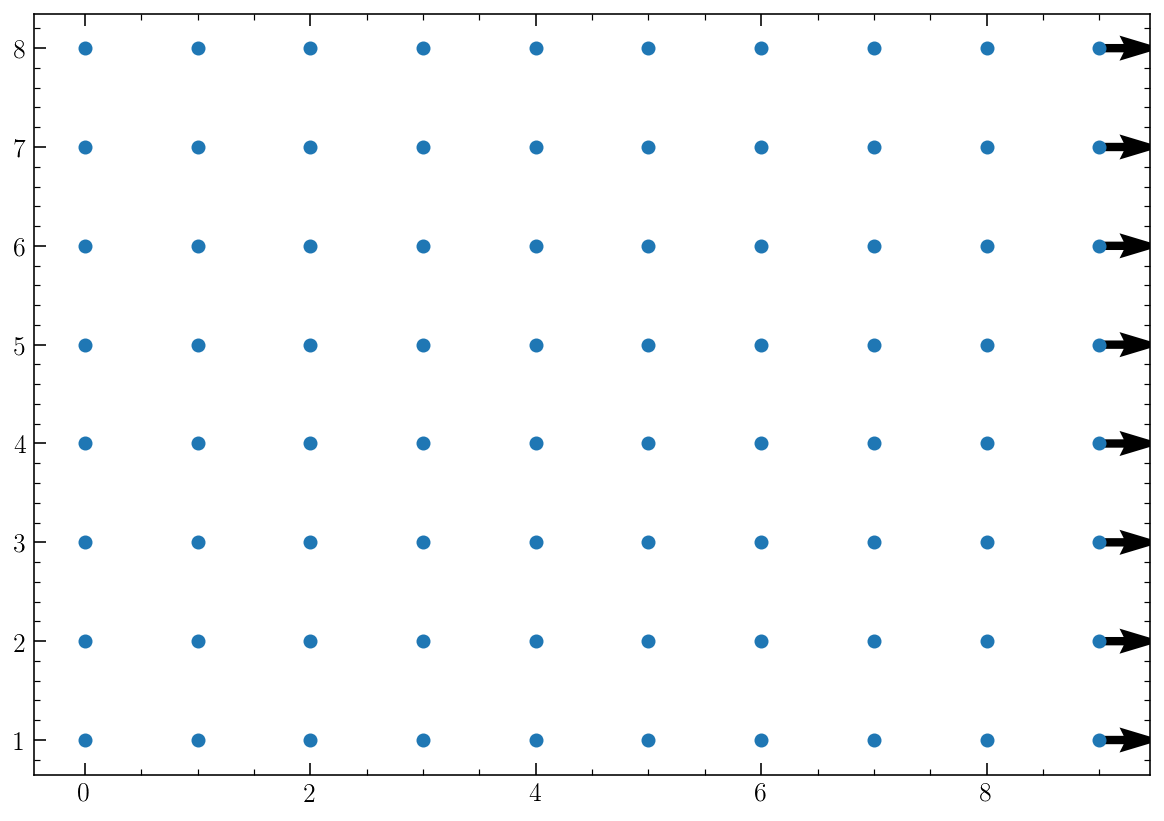

In [14]:
fig, ax = plot_system(lattice, F)

We will integrate this for 15 time units with a time step size of 0.01 time units. Additionally I will heaviliy damp this system, giving the springs a dampening coefficient of 1. Finally I will set the spring stiffness to 50 Force units per length unit.

In [78]:
ts, ys = ym_int_n_model(lattice, massList, sep, 0.01, tf=15, b=1, k=50, F=F)

100%|██████████| 1500/1500 [00:03<00:00, 391.45it/s]


We can animate this in order to see the solid expand, note that depenging on the speed of your long term storage media this line may take upwards of a minute to run.

In [81]:
animate_system('Animations/PullAndRelease.mp4', ys, F, skip=10)

100%|██████████| 1501/1501 [00:23<00:00, 64.92it/s]


In [82]:
from IPython.display import HTML

def playVideo(path):
    return HTML("""
                <video width="320" height="240" controls>
                  <source src="{}" type="video/mp4">
                </video>
                """.format(path))

In [83]:
playVideo('Animations/PullAndRelease.mp4')

Note here that the force remains constant yet the solid reatches an equilibrium stretch. This is because as the solid expands the spring force increases and eventually balances the stretch force. We can calculate youngs modulus using the functions that we already defined by simply telling the youngs modulus function about the recorded state of the system along with what the applied force was

In [86]:
print("Youngs Modulus of this system is: {:0.2f}".format(get_youngs_modulus(ys, F)))

Youngs Modulus of this system is: 5.58


We may also be interested in determing a relationship between youngs modulus and the spring constant and dampening coefficient. I build up a 2 dimensional parameter space of spring constants and dampening coefficients, calculating youngs modulus at each point on the grid. Note that this cell may take signifigant time to run.

In [21]:
nk = 10
nb = 10

K = np.linspace(1, 20, nk)
B = np.linspace(0.05, 1, nb)
e = np.zeros(shape=(nb, nk))
for ib, b in tqdm(enumerate(B), total=nb):
    for ik, k in tqdm(enumerate(K), total=nk, disable=True):
        ts, ys = ym_int_n_model(lattice, massList, sep, 0.01, tf=15, b=b, k=k, F=F, pbar=False)
        e[ib, ik] = get_youngs_modulus(ys, F)

100%|██████████| 10/10 [02:29<00:00, 14.98s/it]


Text(0.5, 0, 'Youngs Modulus')

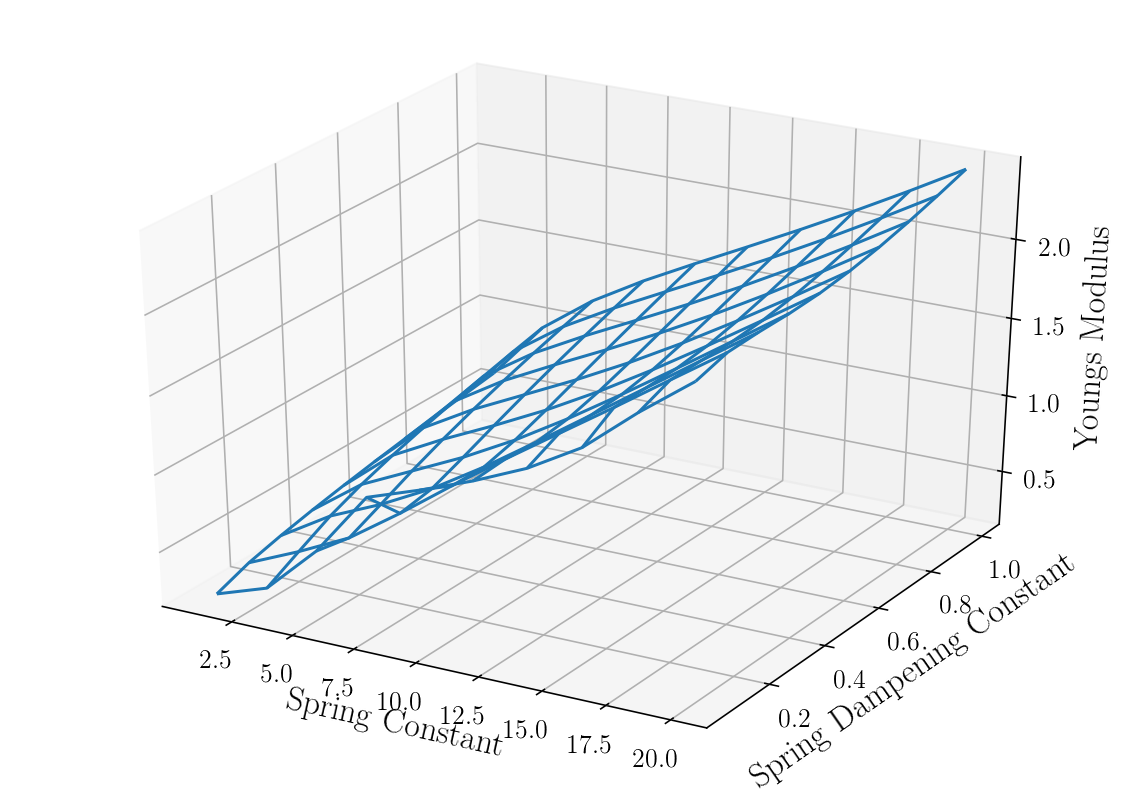

In [22]:
KK, BB = np.meshgrid(K, B)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(KK, BB, e)
ax.set_xlabel('Spring Constant', fontsize=17)
ax.set_ylabel('Spring Dampening Constant', fontsize=17)
ax.set_zlabel('Youngs Modulus', fontsize=17)

We see that the main factor contributing to youngs modulus; however, there is some structure if we slice for varying dampening constants, see below

In [32]:
def line(x, m, b):
    return m*x+b

I will preform a standard linear regression for a slice along both the dampening constant and spring constant. When I preform this constant I will start 3 steps in to remove the inisial transience. This transicene is due to the simulations not running long enough for these solids to reach initial conditions.

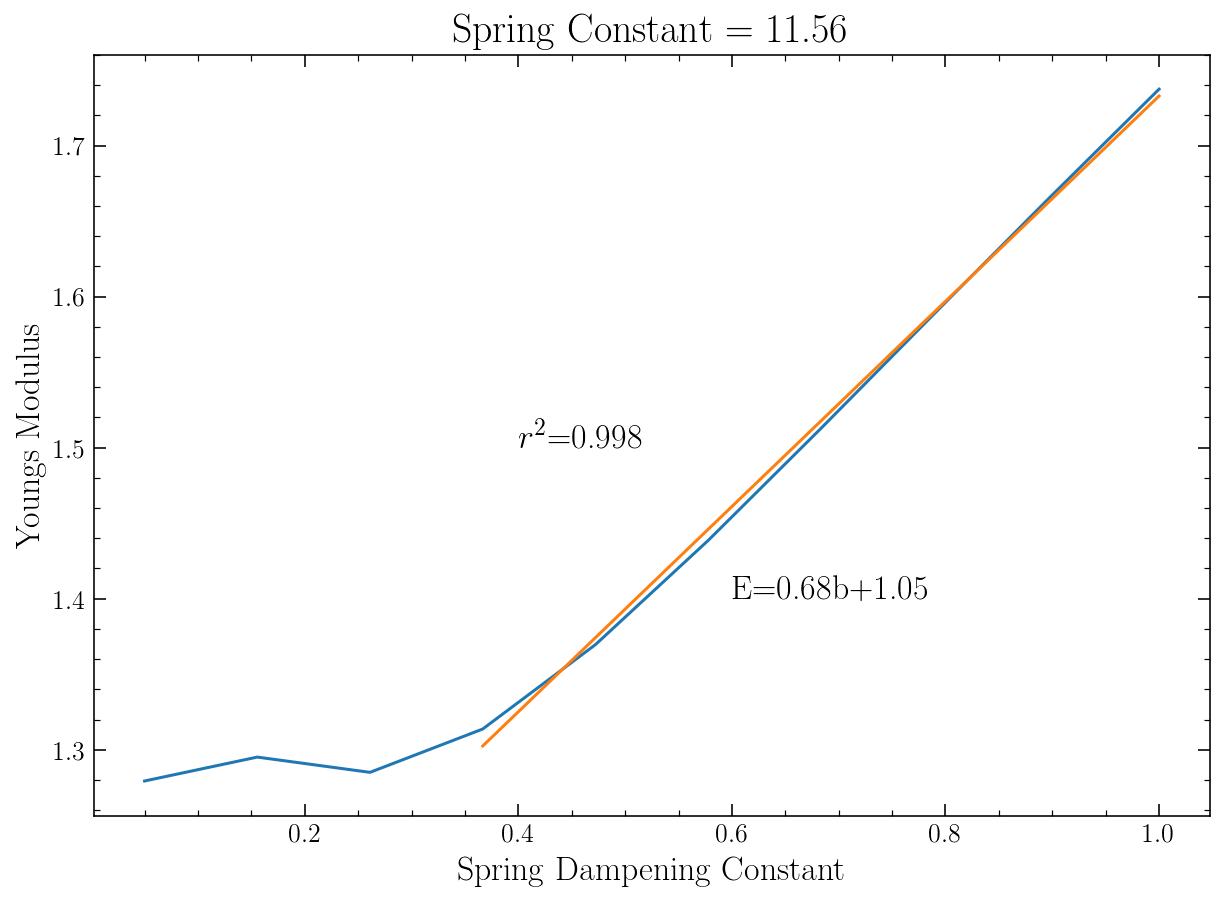

In [53]:
plt.figure(figsize=(10, 7))
plt.plot(B, e[:, 5])
slope, intercept, r_value, p_value, std_err = linregress(B[3:],e[3:, 5])
X = np.linspace(B[3], B[-1], 100)
plt.plot(X, line(X, slope, intercept))
plt.xlabel('Spring Dampening Constant', fontsize=17)
plt.ylabel('Youngs Modulus', fontsize=17)
plt.title('Spring Constant = {:0.2f}'.format(K[5]), fontsize=20)
plt.annotate(r"$r^{{2}}$={:0.3f}".format(r_value**2), xy=(0.4, 1.5), fontsize=17)
plt.annotate(r"E={:0.2f}b+{:0.2f}".format(slope, intercept), xy=(0.6, 1.4), fontsize=17)
plt.show()

If we instead slice at a constant dampening constant to show the structure inherint to the how the spring constant effects youngs modulus

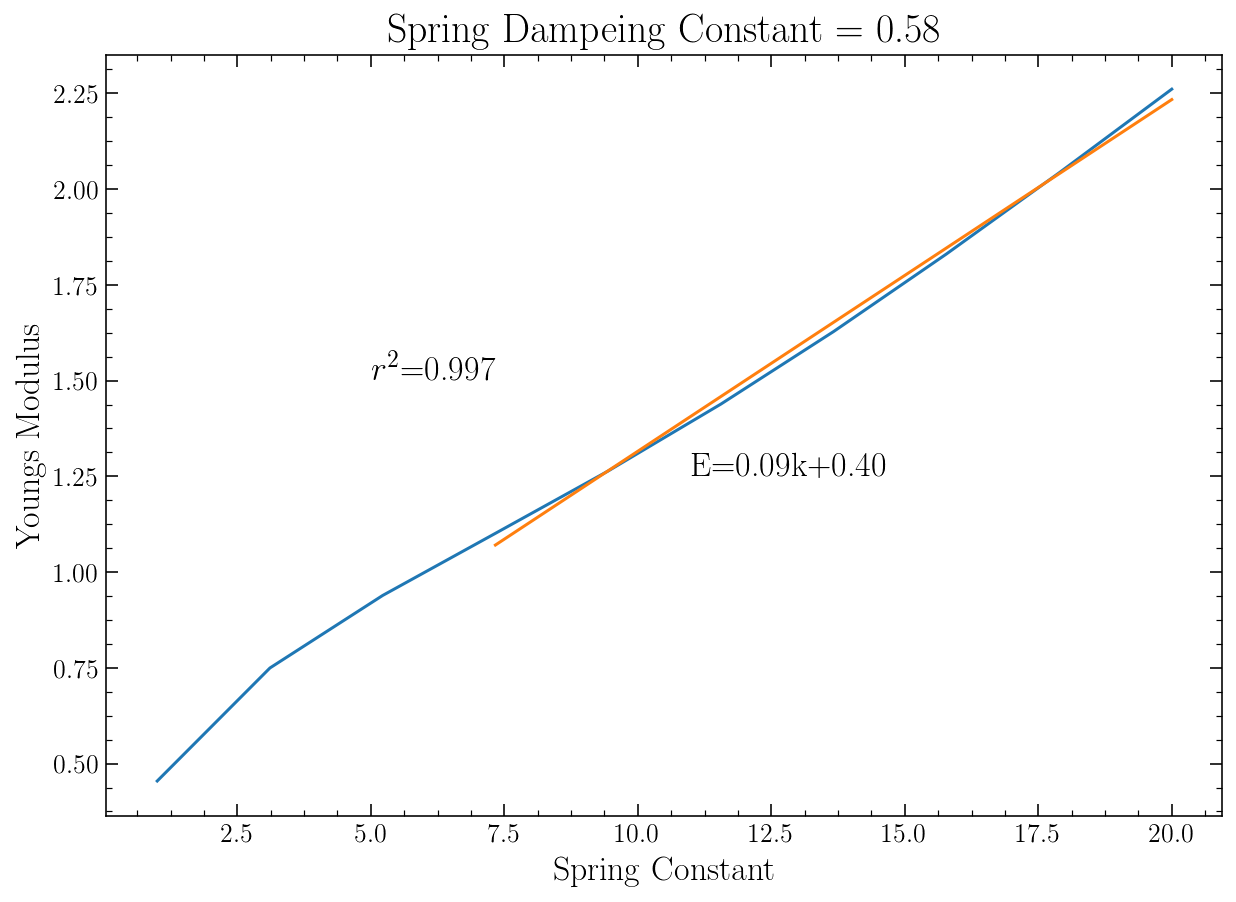

In [54]:
plt.figure(figsize=(10, 7))
plt.plot(K, e[5, :])
slope, intercept, r_value, p_value, std_err = linregress(K[3:],e[5, 3:])
X = np.linspace(K[3], K[-1], 100)
plt.plot(X, line(X, slope, intercept))
plt.xlabel('Spring Constant', fontsize=17)
plt.ylabel('Youngs Modulus', fontsize=17)
plt.title('Spring Dampeing Constant = {:0.2f}'.format(B[5]), fontsize=20)
plt.annotate(r"$r^{{2}}$={:0.3f}".format(r_value**2), xy=(5, 1.5), fontsize=17)
plt.annotate(r"E={:0.2f}k+{:0.2f}".format(slope, intercept), xy=(11, 1.25), fontsize=17)
plt.show()

<h3>Future Work & Conclusions</h3>
Here I have presented a simple method to measure youngs modulus computationally. This could be used to create as the basis of a lab for introductory physics courses. The results of these simulations clearly show a link between the spring constant and youngs modulus, but also between the dampening coefficient and youngs modulus. Future work could take a similar ball spring model as presented here and attempt to observe other properties of solids, such as the coefficient of restitution.